In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import cifar10
from vision import util


Files already downloaded and verified


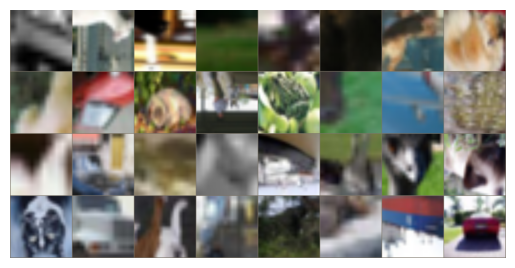

In [2]:
dataset = cifar10.CIFAR10DataSet()
downloader = dataset.train_dataloader()
images, labels = dataset.get_batch(downloader)
util.show_images(images, dataset.mean, dataset.std)

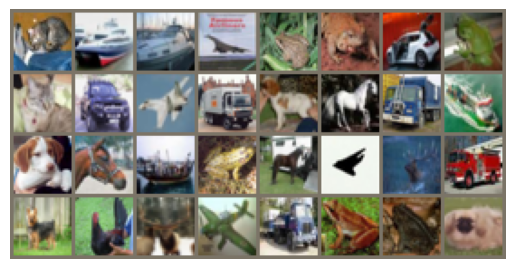

In [3]:

test_downloader = dataset.test_dataloader()
images, labels = dataset.get_batch(test_downloader)
util.show_images(images, dataset.mean, dataset.std)

In [6]:
# Let's take one image and build the initial patch building and positional embedding step.
images.shape

torch.Size([32, 3, 32, 32])

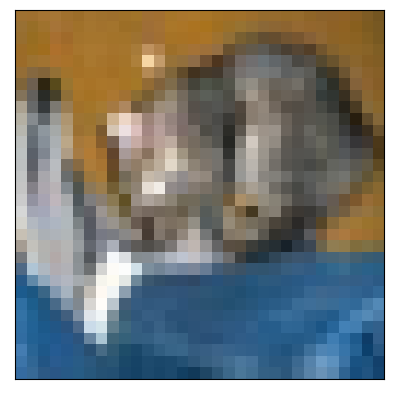

In [5]:

util.show_image(x, dataset.mean, dataset.std)


In [7]:
# Shape of images is batch (B), channel (C), height (H), width (W)
B, C, H, W = images.shape
B, C, H, W

(32, 3, 32, 32)

## Section 3.1
The standard transformer receives as input a $1D$ sequence of token embeddings. To handle $2D$ images, we reshape the image $x \in\mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $x_p \in\mathbb{R}^{N \cdot P^2 \cdot C}$, where $(H,W)$ is the resolution of the original image, and $C$ is the number of channels, $(P,P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$

In [8]:
? images.unfold


Docstring:
unfold(dimension, size, step) -> Tensor

Returns a view of the original tensor which contains all slices of size :attr:`size` from
:attr:`self` tensor in the dimension :attr:`dimension`.

Step between two slices is given by :attr:`step`.

If `sizedim` is the size of dimension :attr:`dimension` for :attr:`self`, the size of
dimension :attr:`dimension` in the returned tensor will be
`(sizedim - size) / step + 1`.

An additional dimension of size :attr:`size` is appended in the returned tensor.

Args:
    dimension (int): dimension in which unfolding happens
    size (int): the size of each slice that is unfolded
    step (int): the step between each slice

Example::

    >>> x = torch.arange(1., 8)
    >>> x
    tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.])
    >>> x.unfold(0, 2, 1)
    tensor([[ 1.,  2.],
            [ 2.,  3.],
            [ 3.,  4.],
            [ 4.,  5.],
            [ 5.,  6.],
            [ 6.,  7.]])
    >>> x.unfold(0, 2, 2)
    tensor([[ 1.,  2.],
    

In [28]:
x_t = [torch.arange(0, 32) for _ in range(32)]
x = torch.stack(x_t, dim=-1)
kc, kh, kw = 2, 2, 2  # kernel size
dc, dh, dw = 2, 2, 2  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

torch.Size([32, 4, 2, 2, 2])


In [29]:
# https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/11
x = torch.randn(1, 500, 500, 500)  # batch, c, h, w
kc, kh, kw = 64, 64, 64  # kernel size
dc, dh, dw = 64, 64, 64  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

torch.Size([1, 343, 64, 64, 64])
tensor(True)


In [30]:
class PatchEmbedding(nn.Module):
    """
    Patch embed layer that takes a 2D image to patches of size P
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_embd = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size, 
            stride=patch_size
            )
        
    def forward(self, x):
        print(f"x.shape: {x.shape}")
        x = self.patch_embd(x)
        print(f"patch_embd(x).shape: {x.shape}")
        x = x.flatten(2)
        print(f"flatten(patch_embed(x)).shape: {x.shape}")
        x = x.transpose(1,2)
        print(f"transpose(flatten(patch_embed(x)),(1,2)).shape: {x.shape}")
        return x

In [44]:
x = images[0]
img_size = x.shape[-1]
p = PatchEmbedding(img_size=img_size, patch_size=4)
y = p(x)
img_size, x.shape, y.shape

x.shape: torch.Size([3, 32, 32])
patch_embd(x).shape: torch.Size([96, 8, 8])
flatten(patch_embed(x)).shape: torch.Size([96, 8, 8])
transpose(flatten(patch_embed(x)),(1,2)).shape: torch.Size([96, 8, 8])


(32, torch.Size([3, 32, 32]), torch.Size([96, 8, 8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 8, 8])

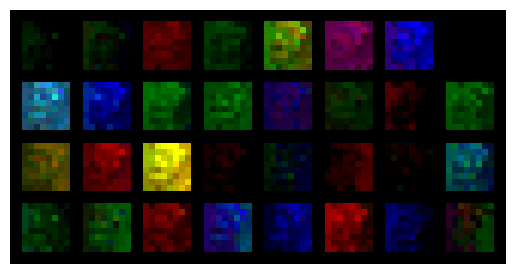

In [50]:
from torchvision import transforms as T

img_patches = torch.reshape(y, (-1, 3, y.shape[-1], y.shape[-1]))
util.show_images(img_patches)
img_patches.shape


In [52]:
3*32*32/(8*8)

48.0